In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Import and clean data

In [2]:
data_path = Path('day-ahead-prices')

# Read in the data
data = []
for file in data_path.glob('*.csv'):
    data.append(pd.read_csv(file))
df = pd.concat(data, axis=0, ignore_index=True)
df.columns = ['datetime', 'price', 'currency', 'bzn_fi'] # Change column names to something more useful
df = df.drop(df.columns[2:], axis=1) # Drop the currency and bzn_fi columns
df['datetime'] = pd.to_datetime(df['datetime'].str[:16], format='%d.%m.%Y %H:%M') # Convert the date_range column to datetime
df = df.set_index('datetime').sort_index() # Set the datetime column as the index
df['price'] = df['price'].replace('-', np.nan).astype(float) # Convert the price column to float


In [3]:
df

,price
datetime,
2019-01-01 00:00:00,10.07
2019-01-01 01:00:00,10.03
2019-01-01 02:00:00,4.56
2019-01-01 03:00:00,4.83
2019-01-01 04:00:00,8.09
...,...
2022-12-31 19:00:00,NaN
2022-12-31 20:00:00,NaN
2022-12-31 21:00:00,NaN


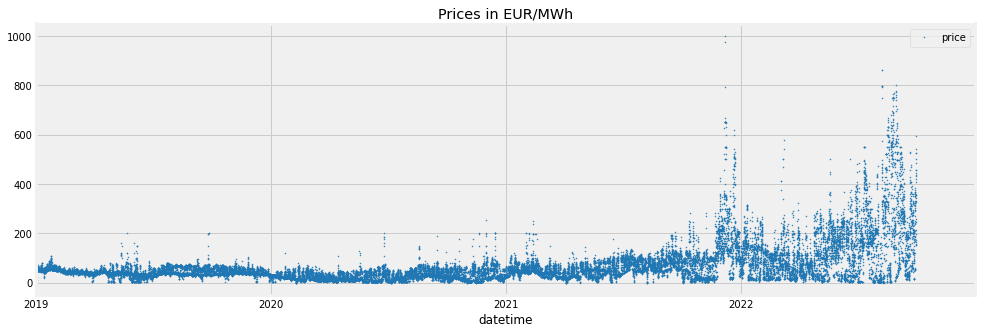

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Prices in EUR/MWh',
        ms=1)
plt.show()

# Calculate simple moving average (SMA)

A simple moving average tells us the unweighted mean of the previous $K$ data points. The larger the value of $K$ the more smooth is the curve, but increasing $K$ decreases accuracy. If the data points are $p_1,p_2,\dots, p_n$ then we calculate the simple moving average.

$$
\begin{align}
{SMA}_k &= \frac{p_{n-k+1}+p_{n-k+2}+\dots+p_n}{k} \\
&= \frac{1}{k}\sum_{i=n-k+1}^n p_i
\end{align}
$$

In [13]:
# calculating simple moving average
# using .rolling(window).mean() ,
# with window size = 72 hours
df['SMA72'] = df['price'].rolling(168).mean()
df['EMA72'] = df['price'].ewm(span=168).mean()

<AxesSubplot:xlabel='datetime'>

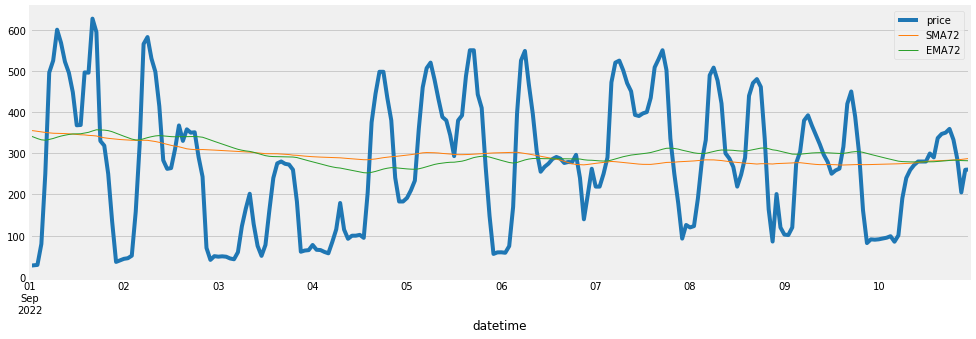

In [14]:
fig, ax = plt.subplots()
df['2022-09-01':'2022-09-10'].plot(y='price', style='-', figsize=(15, 5), color=color_pal[0], ax=ax, ms=1)
df['2022-09-01':'2022-09-10'].plot(y='SMA72', style='-', figsize=(15, 5), color=color_pal[1], ax=ax, lw=1)
df['2022-09-01':'2022-09-10'].plot(y='EMA72', style='-', figsize=(15, 5), color=color_pal[2], ax=ax, lw=1)

# Calculate the difference in percent from the SMA72 value per hour

We define our price index as the price relative to the SMA72 value

In [15]:
df['price_index'] = df['price'] / df['SMA72']

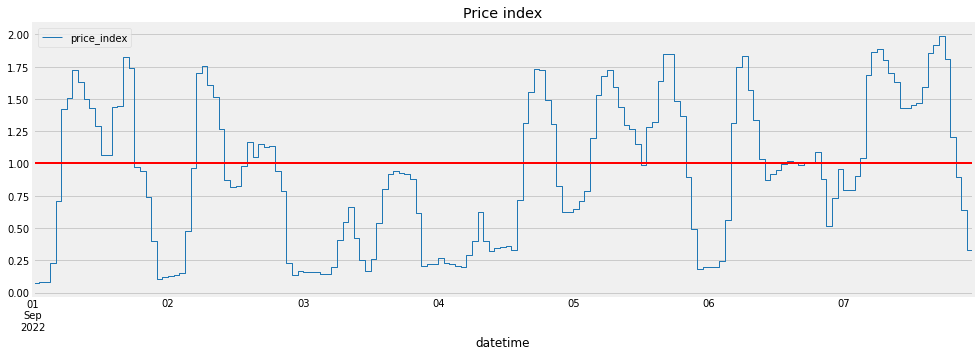

In [17]:
df['2022-09-01':'2022-09-07'].plot(y='price_index', drawstyle="steps-post",
        figsize=(15, 5),
        color=color_pal[0],
        lw=1,
        title='Price index')
plt.axhline(1, color='red', lw=2)
plt.show()